# 06. PyTorch Transfer Learning

## 0. Getting setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split('.')[1]) >= 12, 'torch version should be 1.12+'
    assert int(torchvision.__version__.split('.')[1]) >= 13, 'torchvision version should be 0.13+'
    print(f'torch version: {torch.__version__}')
    print(f'torchvision version: {torchvision.__version__}')
except:
    print(f'[INFO] torch/torchvision versions not as required, installing nightly versions.')
    %pip install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f'torch version: {torch.__version__}')
    print(f'torchvision version: {torchvision.__version__}')

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
Note: you may need to restart the kernel to use updated packages.
torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

# Try to import the goin_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    %git clone https://github.com/mrdbourke/pytorch-deep-learning
    %mv pytorch-deep-learning/going_modular .
    %rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

/home/ewan/PyTorch_Practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/ewan/PyTorch_Practice/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

## 1. Get data

In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f'{image_path} directory exists.')
else:
    print(f'Did not find {image_path} directory, creating one...')
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
        print('Downloading pizza, steak, suhi data...')
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
        print('Unzipping pizza, steak, sushi data...')
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / 'pizza_steak_sushi.zip')

data/pizza_steak_sushi directory exists.


In [5]:
# Setup Dirs
train_dir = image_path / 'train'
test_dir = image_path / 'test'

## 2. Create Datasets and DataLoaders

### 2.1 Creating a transform for `torchvision.models` (manual creation)

In [6]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(),         # 2. Turn image values sto between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225])  # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

In [7]:
import going_modular.data_setup
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                   test_dir=test_dir,
                   transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                   batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f2829dc6410>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Creating training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perfrom same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names                                              

(<torch.utils.data.dataloader.DataLoader at 0x7f2829a76c10>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

### 3.2 Setting up a pretrained model

In [11]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [12]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is 'input_size' not 'input_shape'
        # col_names=['input_size'], # uncomment for smaller output
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.4 Freezing the base model and changing the output layer to suit our needs

In [13]:
# Freeze all base layers in the 'features' section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [14]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)
).to(device)

In [15]:
# # Do a summary *after* freezing the features and changing the output classifier (uncomment for actual output)
summary(
    model,
    input_size=(32, 3, 224, 224), # make sure this is 'input_size', not 'input_shape' (batch_size, color_channels, height, width).
    verbose=0,
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model

In [16]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
from going_modular import engine

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f'[INFO] Total training time: {end_time-start_time:.3f} seconds')

 20%|██        | 1/5 [00:06<00:25,  6.42s/it]

Epoch: 1 | train_loss: 1.0966 | test_loss: 0.8720 | test_acc: 0.7225


 40%|████      | 2/5 [00:12<00:19,  6.42s/it]

Epoch: 2 | train_loss: 0.8693 | test_loss: 0.7726 | test_acc: 0.8352


 60%|██████    | 3/5 [00:19<00:12,  6.39s/it]

Epoch: 3 | train_loss: 0.8146 | test_loss: 0.7203 | test_acc: 0.8267


 80%|████████  | 4/5 [00:25<00:06,  6.46s/it]

Epoch: 4 | train_loss: 0.7052 | test_loss: 0.5953 | test_acc: 0.8759


100%|██████████| 5/5 [00:32<00:00,  6.49s/it]

Epoch: 5 | train_loss: 0.6077 | test_loss: 0.5927 | test_acc: 0.9062
[INFO] Total training time: 32.446 seconds


## 5. Evaluate model by plotting loss curves

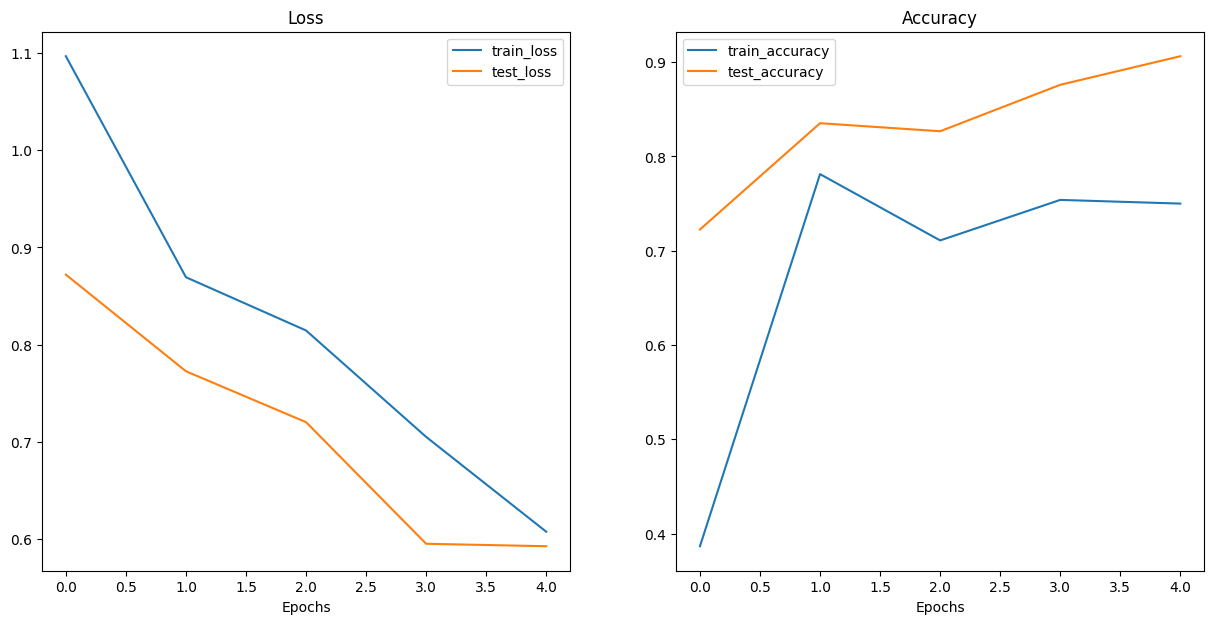

In [18]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

In [19]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and the target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):

    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transform for image (if one doesn't exist)
    if transform is not None:
        image_transform = transforms
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.4060],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform and add an extra dimension to image (model requires sample in [batch_size, color_channels, height, width])
        transformed_iamge = image_transform(img).unsqueeze(dim=0)

        # 7. Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_iamge.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_iamge_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f'Pred: {class_names[target_iamge_pred_label]} | Prob: {target_image_pred_probs.max():.3f}')
    plt.axis(False);

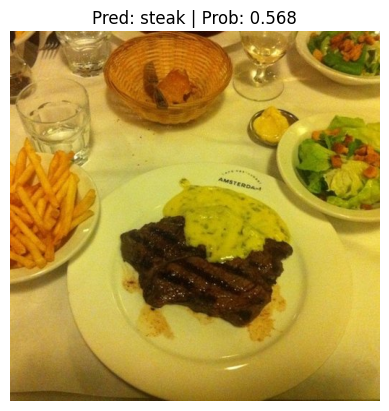

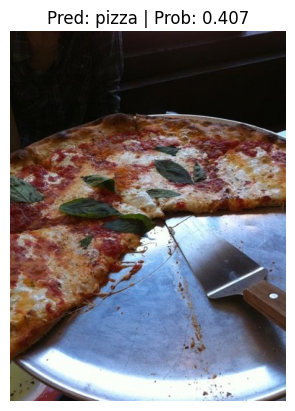

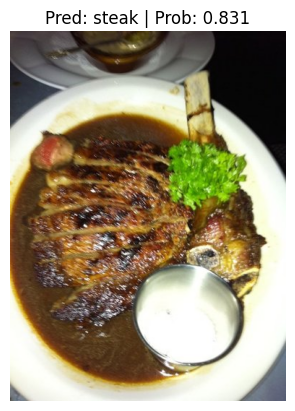

In [20]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg')) # get list of all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### 6.1 Making predictions on a custom image

data/04-pizza-dad.jpeg already exists, skipping download.


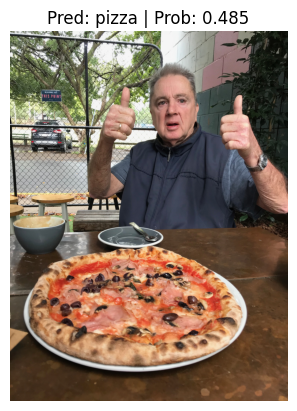

In [21]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / '04-pizza-dad.jpeg'

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f'{custom_image_path} already exists, skipping download.')

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

## Exercises

1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. Check out 03. PyTorch Computer Vision section 10 for ideas.

Making predictions: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


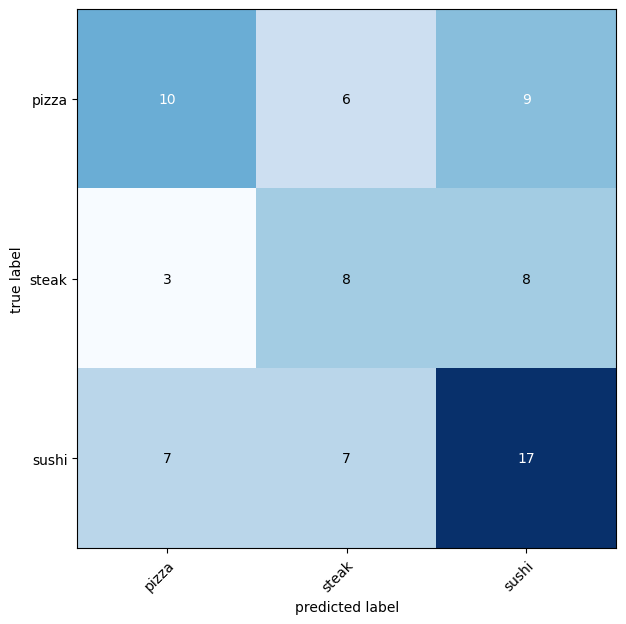

In [22]:
# Imports
import mlxtend
from tqdm.auto import tqdm
from torchvision import datasets
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Create test dataset
test_data = datasets.ImageFolder(test_dir, transform=manual_transforms)
# Make all predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='Making predictions'):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
    y_pred_tensor = torch.cat(y_preds)

# Setup confustion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=3, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_data.targets))

# Plot the confusion matrix
fg, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by wrong prediction and then descending predicted probabilities, this will give you the wrong predictions with the highest prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

Making predictions: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(28)


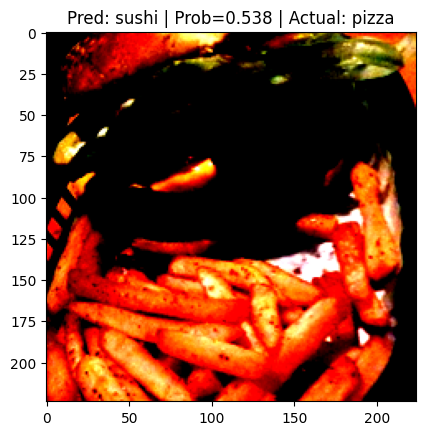

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(40)


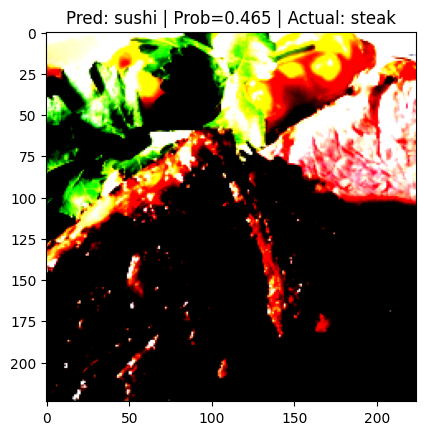

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(12)


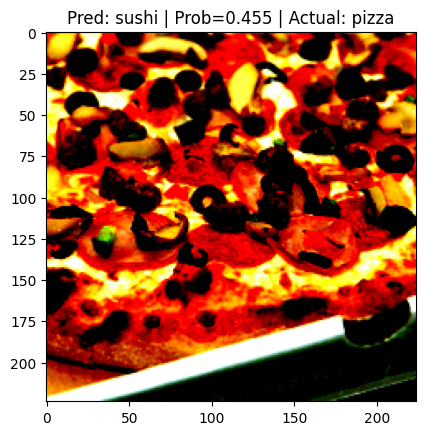

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(22)


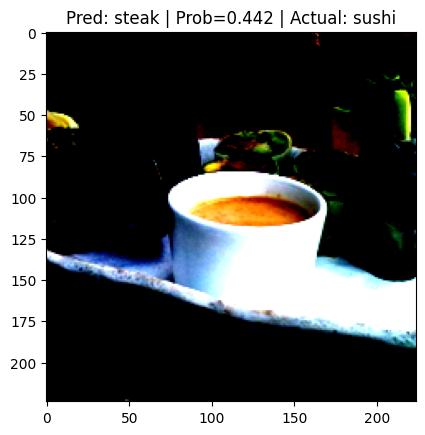

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(16)


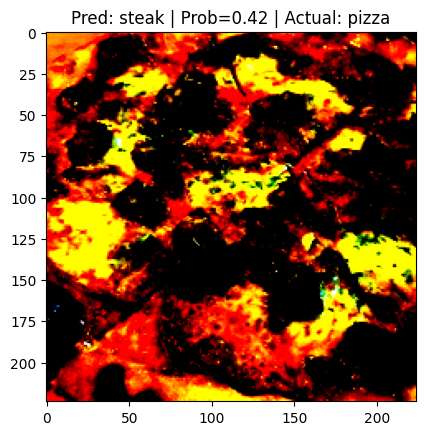

In [23]:
# Predict over  all of test dataset
y_preds = []
y_probs = []
y_trues = []
Xs = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='Making predictions'):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
        y_prob = torch.softmax(y_logit, dim=1).max(dim=1)[0]
        y_probs.append(y_prob)
        y_trues.append(y)
        Xs.append(X)
    y_preds_tensor = torch.cat(y_preds)
    y_probs_tensor = torch.cat(y_probs)
    y_trues_tensor = torch.cat(y_trues)
    Xs_tensor = torch.cat(Xs)

# Grab wrong predictions
wrong_idx = torch.where(y_preds_tensor!=y_trues_tensor.to('cpu'))[0]
wrong_preds = y_preds_tensor[wrong_idx]
wrong_probs = y_probs_tensor[wrong_idx]
wrong_trues = y_trues_tensor[wrong_idx]
wrong_Xs = Xs_tensor[wrong_idx]

# Sort by probability
sorted_probs, sort_idx = torch.sort(wrong_probs, descending=True)
sorted_preds = wrong_preds[sort_idx.to('cpu')]
sorted_trues = wrong_trues[sort_idx.to('cpu')]
sorted_Xs = wrong_Xs[sort_idx.to('cpu')]

# Plot 5 most wrong images
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
for i, idx in enumerate(sort_idx[:5]):
    print(wrong_idx[idx])
    img = test_data[idx][0]
    plt.figure()
    plt.imshow(torch.permute(sorted_Xs[i], (1, 2, 0)))
    plt.title(f'Pred: {class_names[sorted_preds[i]]} | Prob={sorted_probs[i]:.3} | Actual: {class_names[sorted_trues[i]]}')
    plt.show()

First was wrong because it is a picture of a burger, not pizza. Rest may be wrong because data augmentation causes them to have features the model associates with a different class.

3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?

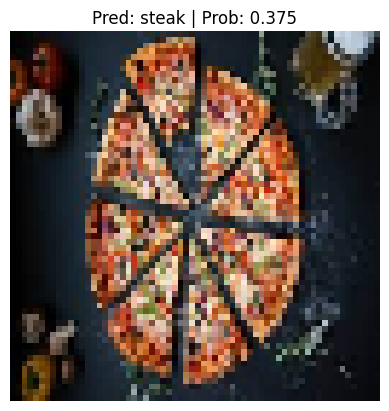

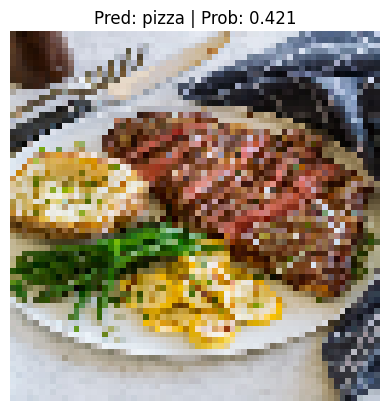

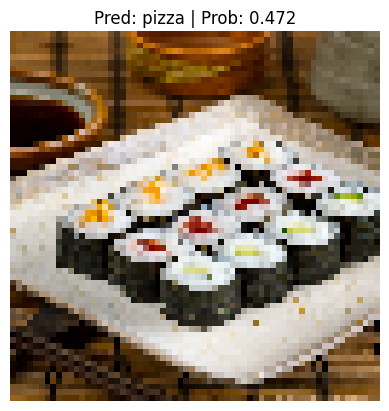

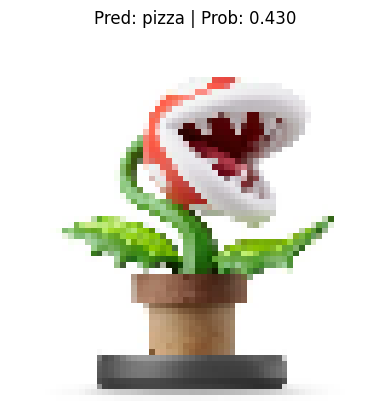

In [26]:
from going_modular.utils import pred_and_plot_image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Image paths
pizza_path = Path('./data/pizza.jpeg')
steak_path = Path('./data/steak.jpeg')
sushi_path = Path('./data/sushi.jpeg')
plant_path = Path('./data/plant.jpeg')

# Transformation pipeline
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

# Predict on custom images
pred_and_plot_image(model=model,
                    image_path=pizza_path,
                    device=device,
                    class_names=class_names,
                    transform=custom_image_transform)
plt.show()
pred_and_plot_image(model=model,
                    image_path=steak_path,
                    device=device,
                    class_names=class_names,
                    transform=custom_image_transform)
plt.show()
pred_and_plot_image(model=model,
                    image_path=sushi_path,
                    device=device,
                    class_names=class_names,
                    transform=custom_image_transform)
plt.show()
pred_and_plot_image(model=model,
                    image_path=plant_path,
                    device=device,
                    class_names=class_names,
                    transform=custom_image_transform)
plt.show();

Model really did not like using my images...

4. Train the model from section 4 above for longer (10 epochs should do), what happens to the performance?

In [28]:
from going_modular import engine

# Create new model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights=weights).to(device)

# Freeze all base layers in the feature extractor
for param in model_2.features.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)
).to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model_2,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f'[INFO] Total training time: {end_time-start_time:.3f} seconds')

 10%|█         | 1/10 [00:06<01:01,  6.88s/it]

Epoch: 1 | train_loss: 1.0966 | test_loss: 0.8720 | test_acc: 0.7225


 20%|██        | 2/10 [00:13<00:54,  6.83s/it]

Epoch: 2 | train_loss: 0.8693 | test_loss: 0.7726 | test_acc: 0.8352


 30%|███       | 3/10 [00:20<00:48,  6.86s/it]

Epoch: 3 | train_loss: 0.8146 | test_loss: 0.7203 | test_acc: 0.8267


 40%|████      | 4/10 [00:27<00:40,  6.81s/it]

Epoch: 4 | train_loss: 0.7052 | test_loss: 0.5953 | test_acc: 0.8759


 50%|█████     | 5/10 [00:34<00:34,  6.87s/it]

Epoch: 5 | train_loss: 0.6077 | test_loss: 0.5927 | test_acc: 0.9062


 60%|██████    | 6/10 [00:41<00:27,  6.84s/it]

Epoch: 6 | train_loss: 0.5748 | test_loss: 0.5675 | test_acc: 0.8466


 70%|███████   | 7/10 [00:48<00:20,  6.87s/it]

Epoch: 7 | train_loss: 0.5036 | test_loss: 0.4728 | test_acc: 0.9375


 80%|████████  | 8/10 [00:54<00:13,  6.87s/it]

Epoch: 8 | train_loss: 0.5942 | test_loss: 0.4991 | test_acc: 0.8759


 90%|█████████ | 9/10 [01:02<00:06,  6.97s/it]

Epoch: 9 | train_loss: 0.5070 | test_loss: 0.4750 | test_acc: 0.8352


100%|██████████| 10/10 [01:08<00:00,  6.90s/it]

Epoch: 10 | train_loss: 0.4657 | test_loss: 0.4224 | test_acc: 0.8958
[INFO] Total training time: 68.982 seconds


Test accuracy goes down, suggesting model is overfitting.

5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the 20% Pizza, Steak, Sushi dataset on the course GitHub. It was created with the notebook extras/04_custom_data_creation.ipynb.


In [29]:
import going_modular.data_setup
from going_modular import engine

# Setup dirs
image_20_path = Path('./data/pizza_steak_sushi_20')
train_20_dir = image_20_path / 'train'
test_20_dir = image_20_path / 'test'

# Create dataloaders
train_20_dataloader, test_20_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_20_dir,
                   test_dir=test_20_dir,
                   transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                   batch_size=32) # set mini-batch size to 32

# Create new model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_3 = torchvision.models.efficientnet_b0(weights=weights).to(device)

# Freeze all base layers in the feature extractor
for param in model_3.features.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)
).to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model_3,
                       train_dataloader=train_20_dataloader,
                       test_dataloader=test_20_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f'[INFO] Total training time: {end_time-start_time:.3f} seconds')

 20%|██        | 1/5 [00:13<00:55, 13.77s/it]

Epoch: 1 | train_loss: 0.9913 | test_loss: 0.6538 | test_acc: 0.8915


 40%|████      | 2/5 [00:26<00:40, 13.42s/it]

Epoch: 2 | train_loss: 0.7396 | test_loss: 0.5241 | test_acc: 0.8881


 60%|██████    | 3/5 [00:40<00:26, 13.44s/it]

Epoch: 3 | train_loss: 0.5493 | test_loss: 0.4510 | test_acc: 0.9068


 80%|████████  | 4/5 [00:53<00:13, 13.31s/it]

Epoch: 4 | train_loss: 0.4858 | test_loss: 0.4043 | test_acc: 0.8915


100%|██████████| 5/5 [01:06<00:00, 13.36s/it]

Epoch: 5 | train_loss: 0.4983 | test_loss: 0.3676 | test_acc: 0.8943
[INFO] Total training time: 66.800 seconds


6. Try a different model from torchvision.models on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?

In [32]:
# Create new model
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_4 = torchvision.models.efficientnet_b2(weights=weights).to(device)

# Freeze all base layers in the feature extractor
for param in model_4.features.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_4.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)
).to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model_4,
                       train_dataloader=train_20_dataloader,
                       test_dataloader=test_20_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f'[INFO] Total training time: {end_time-start_time:.3f} seconds')

 20%|██        | 1/5 [00:18<01:15, 18.99s/it]

Epoch: 1 | train_loss: 0.9848 | test_loss: 0.7719 | test_acc: 0.8665


 40%|████      | 2/5 [00:37<00:56, 18.86s/it]

Epoch: 2 | train_loss: 0.7246 | test_loss: 0.6211 | test_acc: 0.9131


 60%|██████    | 3/5 [00:56<00:37, 18.81s/it]

Epoch: 3 | train_loss: 0.5966 | test_loss: 0.5231 | test_acc: 0.9097


 80%|████████  | 4/5 [01:14<00:18, 18.67s/it]

Epoch: 4 | train_loss: 0.5093 | test_loss: 0.4829 | test_acc: 0.9068


100%|██████████| 5/5 [01:32<00:00, 18.56s/it]

Epoch: 5 | train_loss: 0.4731 | test_loss: 0.4558 | test_acc: 0.8886
[INFO] Total training time: 92.823 seconds
